In [1]:
import pandas as pd
import numpy as np
import math
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from collections import Counter

# Data Exploration

In [2]:
data = pd.read_excel("data/220626_chocolate_bar_rating.xlsx")
data.columns = ['ref', 'company_manufacturer', 'company_location', 'review_date',
       'country_of_bean_origin', 'specific_bean_origin_or_bar_name',
       'cocoa_percent', 'ingredients', 'most_memorable_characteristics',
       'rating']
# data = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2022/2022-01-18/chocolate.csv")
data

,ref,company_manufacturer,company_location,review_date,country_of_bean_origin,specific_bean_origin_or_bar_name,cocoa_percent,ingredients,most_memorable_characteristics,rating
0,2454,5150,U.S.A.,2019,Tanzania,"Kokoa Kamili, batch 1",76%,"3- B,S,C","rich cocoa, fatty, bready",3.25
1,2454,5150,U.S.A.,2019,Madagascar,"Bejofo Estate, batch 1",76%,"3- B,S,C","cocoa, blackberry, full body",3.75
2,2458,5150,U.S.A.,2019,Dominican Republic,"Zorzal, batch 1",76%,"3- B,S,C","cocoa, vegetal, savory",3.50
3,2542,5150,U.S.A.,2021,Fiji,"Matasawalevu, batch 1",68%,"3- B,S,C","chewy, off, rubbery",3.00
4,2542,5150,U.S.A.,2021,India,"Anamalai, batch 1",68%,"3- B,S,C","milk brownie, macadamia,chewy",3.50
...,...,...,...,...,...,...,...,...,...,...
2583,1205,Zotter,Austria,2014,Blend,Raw,80%,"4- B,S*,C,Sa","waxy, cloying, vegetal",2.75
2584,1996,Zotter,Austria,2017,Colombia,"APROCAFA, Acandi",75%,"3- B,S,C","strong nutty, marshmallow",3.75
2585,2036,Zotter,Austria,2018,Blend,"Dry Aged, 30 yr Anniversary bar",75%,"3- B,S,C","fatty, earthy, cocoa",3.00
2586,2170,Zotter,Austria,2018,Congo,Mountains of the Moon,70%,"3- B,S,C","fatty, mild nuts, mild fruit",3.25


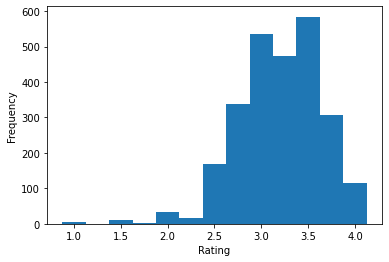

In [3]:
plt.hist(data["rating"], bins=np.arange(0.875, 4.375, 0.25), label="rating")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.savefig("Presentation/ratings_hist.png")
plt.show()

In [4]:
pd.DataFrame(
    {
        "categories": data.loc[
            :,
            [
                "company_manufacturer",
                "company_location",
                "review_date",
                "country_of_bean_origin",
                "specific_bean_origin_or_bar_name",
                "ingredients",
                "most_memorable_characteristics",
            ],
        ].apply(lambda x: len(x.unique()))
    }
)

,categories
company_manufacturer,593
company_location,65
review_date,17
country_of_bean_origin,63
specific_bean_origin_or_bar_name,1643
ingredients,22
most_memorable_characteristics,2545


## Company Manufacturer

In [5]:
comp_shares = pd.DataFrame(columns=["manufacturer", "count", "share"])
for i, comp in enumerate(data["company_manufacturer"].value_counts().index):
    comp_shares.loc[i, "manufacturer"] = comp
    comp_shares.loc[i, "count"] = len(data.loc[data["company_manufacturer"] == comp])
    comp_shares.loc[i, "share"] = round(len(data.loc[data["company_manufacturer"] == comp]) / len(data), 4)
comp_shares

,manufacturer,count,share
0,Soma,57,0.022
1,Fresco,39,0.0151
2,Arete,32,0.0124
3,Bonnat,30,0.0116
4,A. Morin,29,0.0112
...,...,...,...
588,Rococo (Grenada Chocolate Co.),1,0.0004
589,Cacao Arabuco,1,0.0004
590,Britarev,1,0.0004
591,Love Bar,1,0.0004


In [6]:
# create dummies for > 1% manufacturers
manufac = comp_shares.loc[comp_shares["share"] >= 0.01, "manufacturer"]
manufacturer_dummies = pd.DataFrame()

for m in manufac:
    manufacturer_dummies.loc[:, "manufac_" + m] = (data["company_manufacturer"] == m).astype(int)
    
manufacturer_dummies

,manufac_Soma,manufac_Fresco,manufac_Arete,manufac_Bonnat,manufac_A. Morin
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
2583,0,0,0,0,0
2584,0,0,0,0,0
2585,0,0,0,0,0
2586,0,0,0,0,0


## Company Location

<AxesSubplot:>

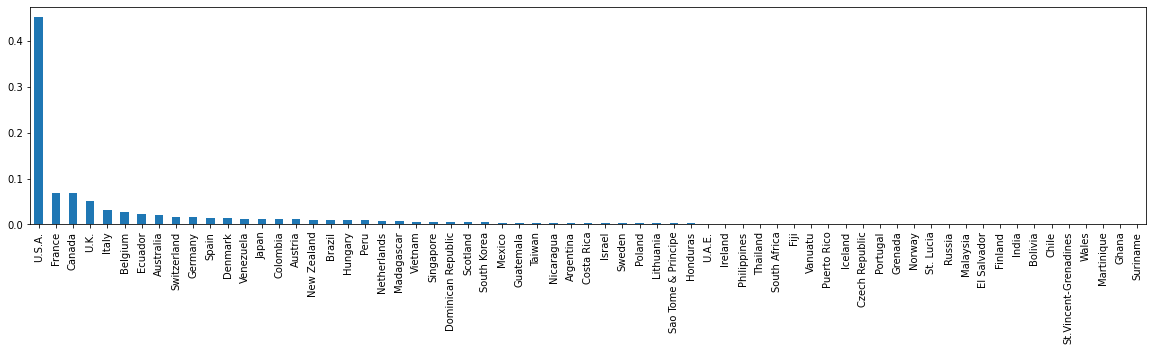

In [7]:
(data["company_location"].value_counts()/len(data)).plot(kind='bar', figsize=(20,4))

<AxesSubplot:>

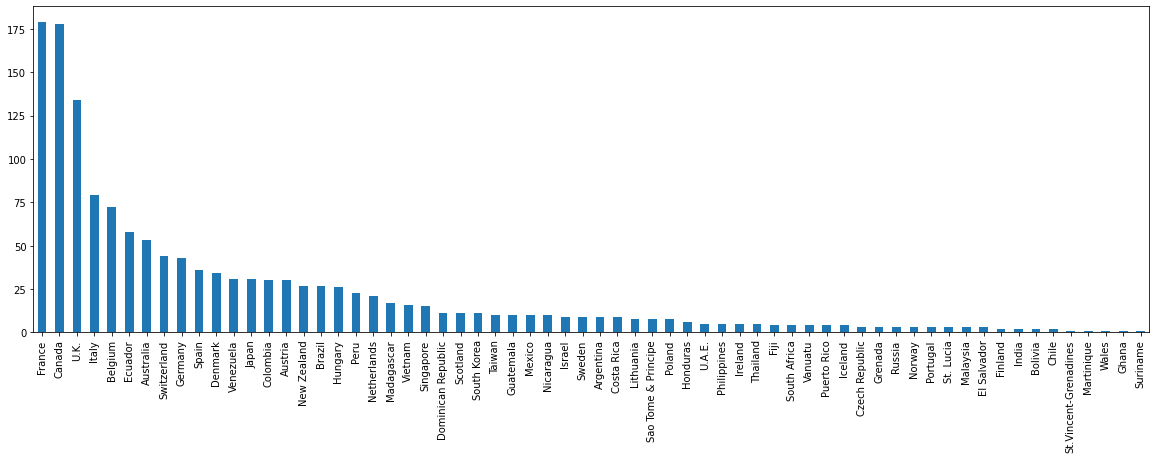

In [8]:
data.loc[data["company_location"] != "U.S.A.", "company_location"].value_counts().plot(kind='bar', figsize=(20,6))

In [9]:
pd.options.display.max_rows = 70
loc_shares = pd.DataFrame(columns=["location", "share"])
for i, loc in enumerate(data["company_location"].value_counts().index):
    loc_shares.loc[i, "location"] = loc
    loc_shares.loc[i, "share"] = len(data.loc[data["company_location"] == loc]) / len(data)
loc_shares

,location,share
0,U.S.A.,0.451314
1,France,0.069165
2,Canada,0.068779
3,U.K.,0.051777
4,Italy,0.030526
5,Belgium,0.027821
6,Ecuador,0.022411
7,Australia,0.020479
8,Switzerland,0.017002
9,Germany,0.016615


In [10]:
loc_shares.loc[loc_shares["share"] <= 0.05, "share"].sum()

0.3589644513137558

In [11]:
loc_shares.loc[loc_shares["share"] <= 0.01, "share"].sum()

0.1190108191653787

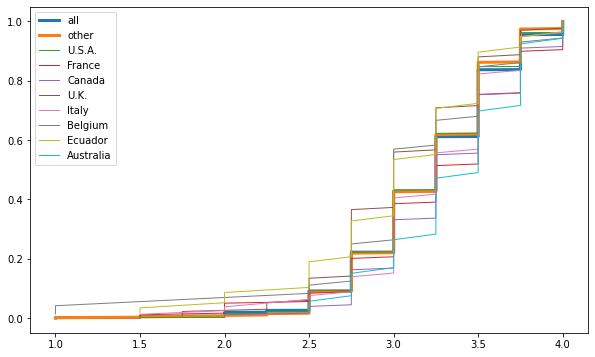

In [12]:
locs = loc_shares.loc[loc_shares["share"] >= 0.02, "location"]
plt.figure(figsize=(10, 6))
ax = plt.subplot(111)

ecdf = ECDF(data.loc[:, "rating"])
ax.plot(ecdf.x, ecdf.y, linewidth=3)

ecdf = ECDF(data.loc[~data["company_location"].isin(locs), "rating"])
ax.plot(ecdf.x, ecdf.y, linewidth=3)

for loc in locs:
    ecdf = ECDF(data.loc[data["company_location"] == loc, "rating"])
    ax.plot(ecdf.x, ecdf.y, linewidth=1)

plt.legend(labels=np.append(["all", "other"], locs.to_list()))
plt.show()

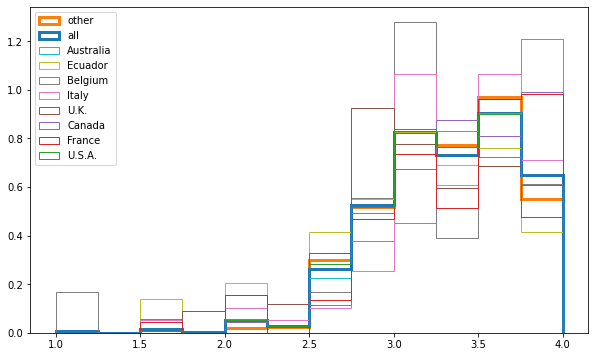

In [13]:
locs = loc_shares.loc[loc_shares["share"] >= 0.02, "location"]
plt.figure(figsize=(10, 6))
ax = plt.subplot(111)

ax.hist(
    [data.loc[:, "rating"], data.loc[~data["company_location"].isin(locs), "rating"]],
    label=["all", "other"],
    bins=len(data["rating"].unique()),
    linewidth=3,
    density=True,
    histtype="step",
)

ax.hist(
    [data.loc[data["company_location"] == loc, "rating"] for loc in locs],
    label=locs.to_list(),
    bins=len(data["rating"].unique()),
    linewidth=1,
    density=True,
    histtype="step",
)

plt.legend(loc="upper left")
plt.show()

In [14]:
# create dummies for > 2% locations
locs = loc_shares.loc[loc_shares["share"] >= 0.02, "location"]
location_dummies = pd.DataFrame()

for loc in locs:
    location_dummies.loc[:, "loc_" + loc] = (data["company_location"] == loc).astype(int)
    
location_dummies

,loc_U.S.A.,loc_France,loc_Canada,loc_U.K.,loc_Italy,loc_Belgium,loc_Ecuador,loc_Australia
0,1,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
2583,0,0,0,0,0,0,0,0
2584,0,0,0,0,0,0,0,0
2585,0,0,0,0,0,0,0,0
2586,0,0,0,0,0,0,0,0


## Review Date

<AxesSubplot:>

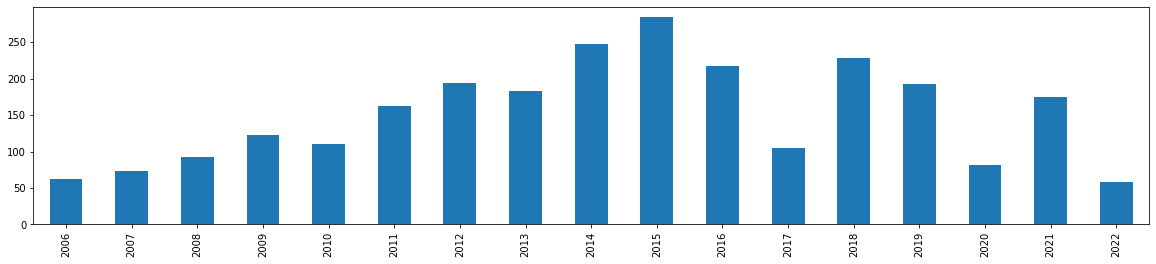

In [15]:
data["review_date"].value_counts().sort_index().plot(kind='bar', figsize=(20,4))

In [16]:
review_date_encoded = data["review_date"] - 2006

## Country of Bean Origin

<AxesSubplot:>

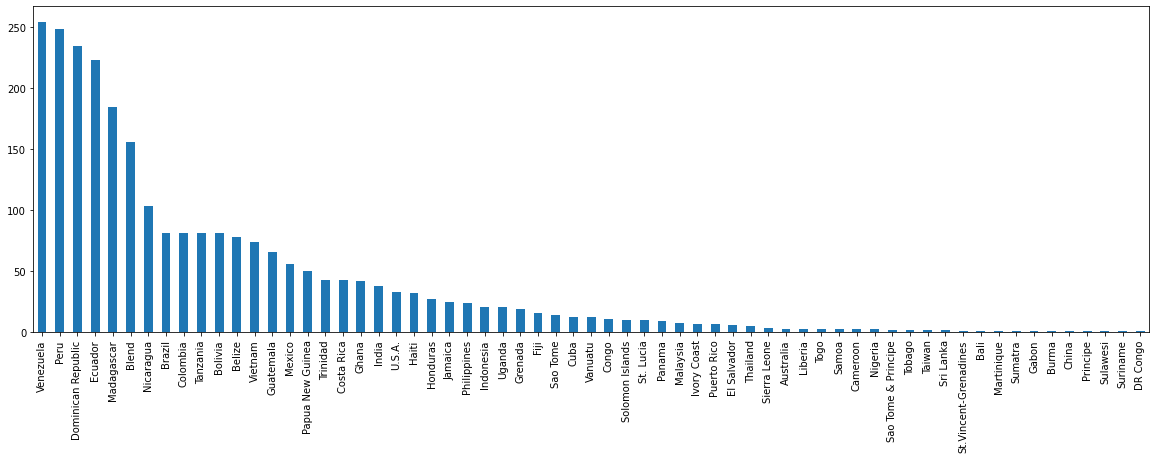

In [17]:
data["country_of_bean_origin"].value_counts().plot(kind='bar', figsize=(20,6))

In [18]:
org_shares = pd.DataFrame(columns=["origin", "count", "share"])
for i, org in enumerate(data["country_of_bean_origin"].value_counts().index):
    org_shares.loc[i, "origin"] = org
    org_shares.loc[i, "count"] = len(data.loc[data["country_of_bean_origin"] == org])
    org_shares.loc[i, "share"] = round(len(data.loc[data["country_of_bean_origin"] == org]) / len(data), 4)
org_shares

,origin,count,share
0,Venezuela,254,0.0981
1,Peru,248,0.0958
2,Dominican Republic,234,0.0904
3,Ecuador,223,0.0862
4,Madagascar,184,0.0711
5,Blend,156,0.0603
6,Nicaragua,103,0.0398
7,Brazil,81,0.0313
8,Colombia,81,0.0313
9,Tanzania,81,0.0313


In [19]:
len(data.loc[data["company_location"] == data["country_of_bean_origin"],]) / len(data)

0.12364760432766615

In [20]:
data.loc[data["company_location"] == data["country_of_bean_origin"], "rating"].mean()

3.128125

In [21]:
data.loc[data["company_location"] != data["country_of_bean_origin"], "rating"].mean()

3.2082231040564375

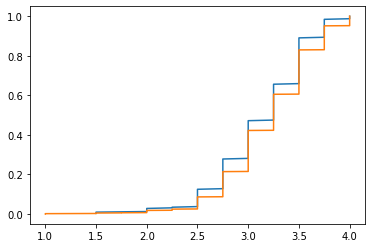

In [22]:
ecdf_same = ECDF(data.loc[data["company_location"] == data["country_of_bean_origin"], "rating"])
ecdf_different = ECDF(data.loc[data["company_location"] != data["country_of_bean_origin"], "rating"])
plt.plot(ecdf_same.x, ecdf_same.y)
plt.plot(ecdf_different.x, ecdf_different.y)
plt.show()

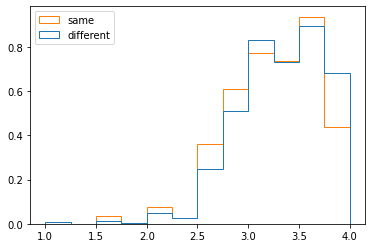

In [23]:
plt.hist(
    [data.loc[data["company_location"] != data["country_of_bean_origin"], "rating"],
    data.loc[data["company_location"] == data["country_of_bean_origin"], "rating"]],
    label=["different", "same"],
    bins=len(data["rating"].unique()),
    density=True,
    histtype="step",
)
plt.legend(loc="upper left")
plt.show()

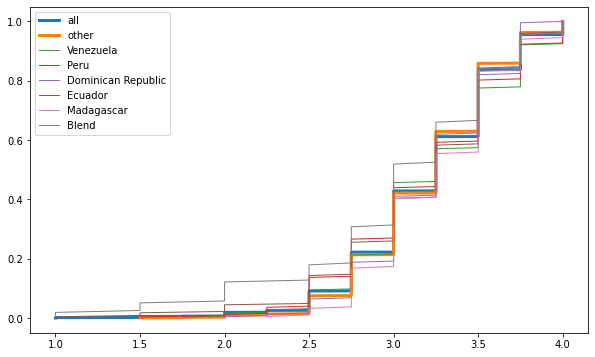

In [24]:
orgs = org_shares.loc[org_shares["share"] >= 0.05, "origin"]
plt.figure(figsize=(10, 6))
ax = plt.subplot(111)

ecdf = ECDF(data.loc[:, "rating"])
ax.plot(ecdf.x, ecdf.y, linewidth=3)

ecdf = ECDF(data.loc[~data["country_of_bean_origin"].isin(orgs), "rating"])
ax.plot(ecdf.x, ecdf.y, linewidth=3)

for org in orgs:
    ecdf = ECDF(data.loc[data["country_of_bean_origin"] == org, "rating"])
    ax.plot(ecdf.x, ecdf.y, linewidth=1)

plt.legend(labels=np.append(["all", "other"], orgs.to_list()))
plt.show()

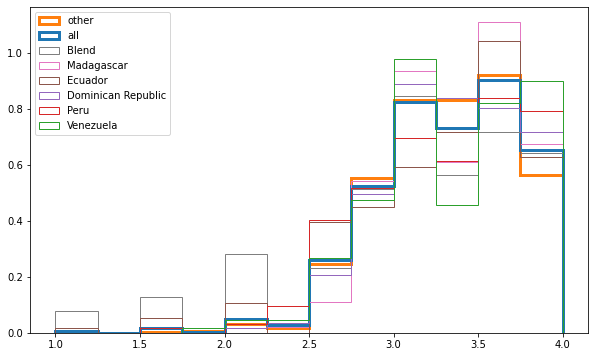

In [25]:
orgs = org_shares.loc[org_shares["share"] >= 0.05, "origin"]
plt.figure(figsize=(10, 6))
ax = plt.subplot(111)

ax.hist(
    [data.loc[:, "rating"], data.loc[~data["country_of_bean_origin"].isin(orgs), "rating"]],
    label=["all", "other"],
    bins=len(data["rating"].unique()),
    linewidth=3,
    density=True,
    histtype="step",
)

ax.hist(
    [data.loc[data["country_of_bean_origin"] == org, "rating"] for org in orgs],
    label=orgs.to_list(),
    bins=len(data["rating"].unique()),
    linewidth=1,
    density=True,
    histtype="step",
)

plt.legend(loc="upper left")
plt.show()

In [26]:
# create dummies for > 2% origins
orgs = org_shares.loc[org_shares["share"] >= 0.02, "origin"]
origin_dummies = pd.DataFrame()

for org in orgs:
    origin_dummies.loc[:, "org_" + org] = (data["country_of_bean_origin"] == org).astype(int)
    
origin_dummies

,org_Venezuela,org_Peru,org_Dominican Republic,org_Ecuador,org_Madagascar,org_Blend,org_Nicaragua,org_Brazil,org_Colombia,org_Tanzania,org_Bolivia,org_Belize,org_Vietnam,org_Guatemala,org_Mexico
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2583,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2584,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2585,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2586,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Cocoa Percent

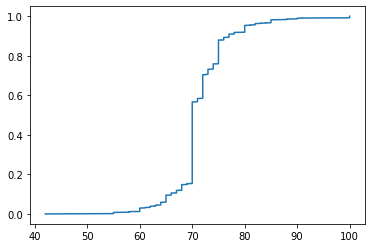

In [27]:
cocoa_percent = data.loc[:,"cocoa_percent"].apply(lambda x: float(x[:-1]))
ecdf_percent = ECDF(cocoa_percent)
plt.plot(ecdf_percent.x, ecdf_percent.y)

## Most Memorable Characteristics

In [28]:
data["most_memorable_characteristics"]

0           rich cocoa, fatty, bready
1        cocoa, blackberry, full body
2              cocoa, vegetal, savory
3                 chewy, off, rubbery
4       milk brownie, macadamia,chewy
                    ...              
2583           waxy, cloying, vegetal
2584        strong nutty, marshmallow
2585             fatty, earthy, cocoa
2586     fatty, mild nuts, mild fruit
2587        muted, roasty, accessible
Name: most_memorable_characteristics, Length: 2588, dtype: object

In [29]:
flavours = (
    data["most_memorable_characteristics"]
    .str.replace(" and", ",")
    .str.split(",\s*|\s", expand=True)
)

flavours_list = []
for i in range(5):
    flavours_list.extend(flavours.iloc[:, i].unique())

flavours_set = set(flavours_list)
for s in ["", None]:
    flavours_set.remove(s)

In [30]:
dupes = [x for x in flavours_list if not x in ["", None]]
for i in range(6):
    print("occur >= "+ str(i+1) + "x:", len(set(dupes)))
    seen = set()
    dupes = [x for x in dupes if x in seen or seen.add(x)]
    if i == 3:
        print(dupes)

occur >= 1x: 578
occur >= 2x: 308
occur >= 3x: 218
occur >= 4x: 135
['fatty', 'nutty', 'fruit', 'banana', 'earthy', 'sandy', 'sour', 'rubber', 'roasty', 'musty', 'cocoa', 'mint', 'creamy', 'notes', 'tart', 'vanilla', 'leather', 'coffee', 'roast', 'brownie', 'anise', 'sweet', 'off', 'berry', 'base', 'dried', 'sticky', 'floral', 'butter', 'licorice', 'nuts', 'burnt', 'spice', 'citrus', 'woody', 'molasses', 'strawberry', 'melon', 'nut', 'intense', 'rich', 'orange', 'choco', 'rubbery', 'lemon', 'smoke', 'ashey', 'harsh', 'spicy', 'grits', 'bitter', 'grassy', 'vegetal']
occur >= 5x: 53
occur >= 6x: 0


### Autocorrect

In [31]:
from autocorrect import Speller
from spellchecker import SpellChecker

In [32]:
spell = Speller()
for f in flavours_set:
    f_corr = spell(f)
    if f != f_corr:
        print(f, "->", f_corr)

earthy -> earth
descript -> script
watery -> water
pungent -> urgent
leathery -> leather
alkalyzed -> analyzed
fudge -> judge
roaste -> roasted
chalky -> chalk
clove -> close
sliglty -> slightly
musty -> must
Roasty -> Roast
winey -> wine
unfixable -> fixable
crunchy -> crunch
waxy -> way
tangy -> tango
alocohol -> alcohol
papaya -> papal
AT -> A
Fruity -> Fruit
macadamia -> academia
nutmeg -> nummer
punchy -> punch
chocolaty -> chocolate
carame -> came
raisns -> raises
petro -> metro
pasty -> party
sugary -> sugar
nibs -> nis
sligthly -> slightly
alluring -> alluding
smokey -> smoke
unrefined -> undefined
oreo -> ordo
nutty -> duty
licoric -> iconic
walnuts -> walnut
chewy -> chew
unripe -> unlike
astingent -> stringent
overyly -> overly
cheesy -> cheese
spicey -> spices
fudgey -> budget
vanila -> manila
non-descript -> non-script
Hammy -> Army
meaty -> meat
prononced -> pronounced
roasty/smokey -> roast/smoke
hebs -> hubs
earty -> party
spiciness -> sickness
brownie -> browne
sandpap

In [33]:
spell = SpellChecker()
for f in flavours_set:
    f_corr = spell.correction(f)
    if f != f_corr:
        print(f, "->", f_corr)

mouthfeel -> mouthful
descript -> describe
alkalyzed -> analyzed
roaste -> roast
sliglty -> slighty
Roasty -> roast
winey -> wine
unfixable -> unlikable
alocohol -> alcohol
dirt/ -> dirty
astringcy -> stringy
carame -> caramel
"Andes" -> andes
(fig) -> fig
raisns -> rains
sl. -> sly
ham-like -> hairlike
sl -> so
sligthly -> slightly
licoric -> licorice
astingent -> astringent
overyly -> overly
spicey -> spice
vanila -> vanilla
non-descript -> nondescript
prononced -> pronounced
hebs -> he's
earty -> party
astringency -> stringency
molassses -> molasses
cheesey -> cheese
cardamon -> cardamom
roasty -> roast
ligt -> light
rasin -> rain
smomkey -> smokey
nibby -> dibby
mildy -> mild
klingy -> clingy
XL -> al
pomegrant -> pomegranate
cocounut -> coconut
cinamon -> cinnamon
"rolo" -> prolon
pastey -> pastry
dutched? -> ditched
sticy -> stick
lavendar -> lavender
malitol -> marital
fertilzer -> fertilizer
accesible -> accessible
brownine -> brownie
blackcherry -> blackberry
smoth -> smooth
d

In [34]:
spell.unknown(flavours_set)

{'"andes"',
 '"rolo"',
 '(fig)',
 'accesible',
 'aftertaste',
 'alkalyzed',
 'alocohol',
 'ashey',
 'astingent',
 'astringcy',
 'astringency',
 'astringnet',
 'blackcherry',
 'blackpepper',
 'bready',
 'brownine',
 'cadbury',
 'candy-like',
 'carame',
 'cardamon',
 'cheesey',
 'cinamon',
 'cocounut',
 'cooa',
 'descript',
 'dirt/',
 'dirty/burnt',
 'distinquished',
 'domintates',
 'dutched?',
 'earty',
 'fertilzer',
 'floral-spice',
 'fudge-like',
 'ham-like',
 'hebs',
 'intens',
 'klingy',
 'lavendar',
 'licoric',
 'ligt',
 'malitol',
 'mildy',
 'molassses',
 'mouthfeel',
 'nibby',
 'non-descript',
 'overyly',
 'pastey',
 'peanutbutter',
 'pomegrant',
 'prononced',
 'raisiny',
 'raisns',
 'rasin',
 'roaste',
 'roasty',
 'roasty/smokey',
 'sl',
 'sl.',
 'sliglty',
 'sligt',
 'sligthly',
 'smomkey',
 'smoth',
 'spciy',
 'spice/herb',
 'spicey',
 'sticy',
 'sublte',
 'tea-like',
 'trop.',
 'unfixable',
 'vanila',
 'vanilla(n)',
 'w/',
 'winey',
 'woody/green',
 'wtf',
 'xl'}

In [35]:
from textblob import Word

In [36]:
#for f in flavours_set:
#    word = Word(f)
#    print(f)
#    print(word.spellcheck())

medley
[('merely', 0.9043062200956937), ('madly', 0.03349282296650718), ('meddle', 0.028708133971291867), ('motley', 0.014354066985645933), ('morley', 0.004784688995215311), ('mele', 0.004784688995215311), ('meddler', 0.004784688995215311), ('eley', 0.004784688995215311)]
mouthfeel
[('mouthfeel', 0.0)]
ending
[('ending', 1.0)]
floral
[('flora', 1.0)]
uncontrolled
[('uncontrolled', 1.0)]
is
[('is', 1.0)]
walnut
[('walnut', 1.0)]
dirty/burnt
[('dirty/burnt', 0.0)]
leather
[('leather', 1.0)]
earthy
[('earthy', 1.0)]
descript
[('rescript', 1.0)]
watery
[('watery', 1.0)]
pungent
[('pungent', 1.0)]
acidity
[('aridity', 1.0)]
well
[('well', 1.0)]
atypical
[('typical', 1.0)]
slow
[('slow', 1.0)]
oranges
[('oranges', 1.0)]
multiple
[('multiple', 1.0)]
some
[('some', 1.0)]
brown
[('brown', 1.0)]
leathery
[('leathery', 1.0)]
ripe
[('ripe', 1.0)]
alkalyzed
[('analyzed', 1.0)]
fudge
[('judge', 0.9375), ('budge', 0.0625)]
butt
[('butt', 1.0)]
roaste
[('roast', 0.8), ('roasted', 0.2)]
mild
[('mild', 

[('Fruit', 0.2702702702702703), ('Purity', 0.24324324324324326), ('Fruits', 0.1891891891891892), ('Bruit', 0.13513513513513514), ('Rusty', 0.05405405405405406), ('Equity', 0.05405405405405406), ('Trusty', 0.04054054054054054), ('Crusty', 0.013513513513513514)]
herbal
[('verbal', 1.0)]
residue
[('residue', 1.0)]
baked
[('baked', 1.0)]
mix
[('mix', 1.0)]
basic
[('basic', 1.0)]
metal
[('metal', 1.0)]
cacao
[('canal', 0.7422680412371134), ('sacro', 0.05154639175257732), ('cargo', 0.05154639175257732), ('cava', 0.030927835051546393), ('facto', 0.020618556701030927), ('carlo', 0.020618556701030927), ('cameo', 0.020618556701030927), ('cabal', 0.020618556701030927), ('cocoa', 0.010309278350515464), ('cavae', 0.010309278350515464), ('campo', 0.010309278350515464), ('cairo', 0.010309278350515464)]
gateway
[('gateway', 1.0)]
pistachio
[('pistachio', 0.0)]
bar
[('bar', 1.0)]
fat
[('fat', 1.0)]
macadamia
[('macadamia', 0.0)]
nutmeg
[('nutmeg', 0.0)]
off
[('off', 1.0)]
true
[('true', 1.0)]
punchy
[(

KeyboardInterrupt: 

In [37]:
import nltk
from nltk.stem.wordnet import WordNetLemmatizer

In [38]:
ps = nltk.stem.SnowballStemmer("english")

In [39]:
for f in flavours_set:
    f_stem = ps.stem(f)
    if f != f_stem:
        print(f, "->", f_stem)

ending -> end
uncontrolled -> uncontrol
earthy -> earthi
watery -> wateri
acidity -> acid
atypical -> atyp
oranges -> orang
multiple -> multipl
leathery -> leatheri
alkalyzed -> alkalyz
fudge -> fudg
roaste -> roast
berry -> berri
chalky -> chalki
sliglty -> sliglti
very -> veri
musty -> musti
Fruit -> fruit
Roasty -> roasti
evolves -> evolv
unfixable -> unfix
perfectly -> perfect
crunchy -> crunchi
gentle -> gentl
waxy -> waxi
olive -> oliv
candy -> candi
tangy -> tangi
defined -> defin
strawberries -> strawberri
astringcy -> astringci
notes -> note
smokiness -> smoki
AT -> at
mildly -> mild
Fruity -> fruiti
residue -> residu
baked -> bake
punchy -> punchi
chocolaty -> chocolati
carame -> caram
"Andes" -> "andes"
grounds -> ground
unbalanced -> unbalanc
dry -> dri
raisns -> raisn
body -> bodi
spicy -> spici
issues -> issu
ambiguous -> ambigu
early -> earli
edge -> edg
peanutbutter -> peanutbutt
pasty -> pasti
cooked -> cook
muddy -> muddi
heavy -> heavi
medicine -> medicin
sugary -> s

In [40]:
for f in flavours_set:
    f_changed = WordNetLemmatizer().lemmatize(f)
    if f != f_changed:
        print(f)
        print(WordNetLemmatizer().lemmatize(f))

oranges
orange
strawberries
strawberry
notes
note
grounds
ground
issues
issue
nibs
nib
walnuts
walnut
hints
hint
oats
oat
plums
plum
molassses
mola
grits
grit
prunes
prune
spices
spice
carrots
carrot
herbs
herb
lacks
lack
pieces
piece
cherries
cherry
blackberries
blackberry
less
le
fades
fade
flavors
flavor
dates
date
grapes
grape
blueberries
blueberry
cranberries
cranberry
ends
end
nuts
nut
raisins
raisin
raspberries
raspberry
undertones
undertone
berries
berry


### Embeddings

In [31]:
import tensorflow_hub as hub
from sklearn.decomposition import PCA

In [197]:
embed = hub.load("https://tfhub.dev/google/Wiki-words-250-with-normalization/2")
#embed = hub.load("https://tfhub.dev/google/nnlm-en-dim50-with-normalization/2")

In [198]:
flavours_embedded = embed(data["most_memorable_characteristics"])

In [211]:
pca = PCA(n_components=250)
pca.fit(flavours_embedded)
print("explained variance:\n", pca.explained_variance_ratio_[0:67])
print("\nsum sum first 67:\n", sum(pca.explained_variance_ratio_[0:67]))
print("\nsum sum first 22:\n", sum(pca.explained_variance_ratio_[0:22]))

explained variance:
 [0.1731333  0.10158812 0.08309903 0.06254793 0.04824082 0.0461495
 0.03998854 0.03460106 0.02640197 0.02482791 0.02416396 0.02017378
 0.01753202 0.01497721 0.01405252 0.01329271 0.01265385 0.0107833
 0.01052255 0.00930053 0.00868887 0.00854839 0.00776559 0.00736068
 0.00694382 0.00645688 0.00607234 0.00564636 0.00545298 0.00517332
 0.00479933 0.00478754 0.00453819 0.00410424 0.00404954 0.0037481
 0.00357342 0.00348444 0.0034252  0.00325583 0.00313691 0.0030978
 0.00288034 0.00282634 0.00279939 0.0025223  0.00241999 0.00236743
 0.00221756 0.00216527 0.00211321 0.00206358 0.00196389 0.00195103
 0.00189195 0.00185078 0.00178998 0.00169303 0.00158859 0.0015253
 0.00152129 0.00150511 0.00142092 0.0014084  0.00137812 0.001335
 0.00129437]

sum sum first 67:
 0.950633564024413

sum sum first 22:
 0.8052678825173687


In [213]:
flavours_pca = pca.fit_transform(flavours_embedded)
flavours_pca.shape

(2588, 250)

In [214]:
flavours_pca = pd.DataFrame(flavours_pca, columns = ["flavour" + str(i+1) for i in range(250)])
flavours_pca

,flavour1,flavour2,flavour3,flavour4,flavour5,flavour6,flavour7,flavour8,flavour9,flavour10,...,flavour241,flavour242,flavour243,flavour244,flavour245,flavour246,flavour247,flavour248,flavour249,flavour250
0,0.042539,-0.318266,-0.260561,0.100184,0.451360,0.240832,-0.089521,0.001307,0.066255,-0.031070,...,0.000277,-0.000015,0.000322,-0.000325,0.000146,-0.000086,0.000136,-0.000071,-0.000445,0.000279
1,0.162432,-0.326868,-0.294836,-0.041397,-0.163356,0.051642,-0.080285,-0.091534,0.123810,-0.205580,...,0.020881,0.005296,-0.006808,-0.004722,-0.004410,-0.010820,0.014052,-0.000223,0.001513,-0.005418
2,-0.420486,-0.214272,-0.128944,0.138356,0.071909,0.236177,0.001735,-0.018482,-0.046782,-0.111998,...,0.002523,-0.000816,-0.000654,-0.000217,-0.002107,0.001074,-0.000580,0.000715,0.000183,-0.002944
3,0.144357,0.200121,-0.072423,0.167092,-0.259868,-0.331151,-0.108609,0.278007,0.241207,-0.153140,...,-0.000650,-0.001109,0.001974,-0.000718,0.001696,0.002021,-0.003138,0.002196,-0.001696,-0.001491
4,-0.687858,0.133098,-0.186833,0.092204,-0.056778,-0.069925,-0.056994,0.139532,0.010918,0.127571,...,0.006781,0.006978,-0.000319,0.005599,-0.005120,-0.002559,-0.003731,-0.006549,-0.003270,-0.008191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2583,0.236293,-0.056974,0.449042,0.234391,0.117740,0.026489,-0.134724,0.058768,-0.163605,-0.319073,...,0.000851,0.006645,-0.002267,-0.004355,0.001407,-0.000155,0.006561,-0.005125,0.005653,-0.000034
2584,0.108436,0.455514,-0.165378,0.024161,-0.094018,-0.011729,-0.056190,-0.075467,0.107719,-0.049606,...,-0.000057,-0.001531,-0.000206,-0.000242,0.000198,-0.001131,0.001563,0.002472,0.000938,0.000715
2585,-0.132193,-0.033795,-0.051413,0.165338,0.443314,0.188866,-0.221237,0.078298,-0.024386,-0.142298,...,0.000459,-0.000323,0.000020,-0.000191,0.000362,0.000350,-0.000133,-0.000572,-0.000104,0.000664
2586,-0.081491,-0.149969,0.012406,-0.485051,0.495941,-0.192430,-0.309104,0.048696,-0.083442,0.167241,...,-0.002021,-0.000004,0.001081,-0.000972,0.000162,0.001475,0.000157,-0.000910,0.000760,0.001327


In [148]:
flavour_words = (
    data["most_memorable_characteristics"]
    .str.replace(" and", ",")
    .str.split(",\s*|\s", expand=True)
)

flavour_words = flavour_words.join(data["rating"])
flavour_words.columns = ["flavour" + s for s in ["1", "2", "3", "4", "5", "6"]] + [
    "rating"
]
flavour_words.reset_index(inplace=True)

flavour_words = pd.wide_to_long(
    flavour_words, stubnames=["flavour"], i="index", j="position"
)

flavour_words = flavour_words.dropna().reset_index().loc[:, ["flavour", "rating"]]
flavour_words

,flavour,rating
0,rich,3.25
1,cocoa,3.75
2,cocoa,3.50
3,chewy,3.00
4,milk,3.50
...,...,...
8867,nut,3.50
8868,back,3.25
8869,long,4.00
8870,sour,3.00


In [ ]:
words_embedded = embed(flavour_words["flavour"])
words_embedded

In [ ]:
pca = PCA(n_components=42)
pca.fit(words_embedded)
print("explained variance:\n", pca.explained_variance_ratio_)
print("sum:", sum(pca.explained_variance_ratio_))

## Ingredients

B = Beans $\newline$
S = Sugar $\newline$
S* = Sweetener other than white cane or beet sugar $\newline$
C = Cocoa Butter $\newline$
V = Vanilla $\newline$
L = Lecithin $\newline$
Sa = Salt $\newline$

In [215]:
ingr_list = data["ingredients"].dropna().unique()
ingr_list.sort()
list(ingr_list)

['1- B',
 '2- B,C',
 '2- B,S',
 '2- B,S*',
 '3- B,S*,C',
 '3- B,S*,Sa',
 '3- B,S,C',
 '3- B,S,L',
 '3- B,S,V',
 '4- B,S*,C,L',
 '4- B,S*,C,Sa',
 '4- B,S*,C,V',
 '4- B,S*,V,L',
 '4- B,S,C,L',
 '4- B,S,C,Sa',
 '4- B,S,C,V',
 '4- B,S,V,L',
 '5- B,S,C,L,Sa',
 '5- B,S,C,V,L',
 '5-B,S,C,V,Sa',
 '6-B,S,C,V,L,Sa']

In [216]:
data.loc[data["ingredients"].isnull(),]

,ref,company_manufacturer,company_location,review_date,country_of_bean_origin,specific_bean_origin_or_bar_name,cocoa_percent,ingredients,most_memorable_characteristics,rating
88,1964,Amazing Cacao,Russia,2017,Peru,Maranon,70%,NaN,"raisins, pungent",3.00
89,1964,Amazing Cacao,Russia,2017,Peru,Platan Bajo,70%,NaN,"few grits, blackcherry, licorice",3.50
167,486,Artisan du Chocolat,U.K.,2010,Venezuela,Venezuela,100%,NaN,"very nutty, very bitter",1.75
303,81,Bonnat,France,2006,Blend,One Hundred,100%,NaN,"acidic, bitter, dry",1.50
330,341,Bouga Cacao (Tulicorp),Ecuador,2009,Ecuador,"El Oro, Hacienda de Oro",100%,NaN,"cardboard, very bitter, floral",1.50
...,...,...,...,...,...,...,...,...,...,...
2478,153,Vintage Plantations (Tulicorp),U.S.A.,2007,Ecuador,"Los Rios, Rancho Grande 2004/2007",100%,NaN,"bland, mild fruit, strong bitter",2.00
2479,153,Vintage Plantations (Tulicorp),U.S.A.,2007,Ecuador,"Los Rios, Rancho Grande 2004/2007",90%,NaN,"some fruit, strong bitter",2.00
2480,153,Vintage Plantations (Tulicorp),U.S.A.,2007,Ecuador,"Los Rios, Rancho Grande 2004/2007",75%,NaN,"cocoa,earthy,very astringent",3.00
2505,733,Whittakers,New Zealand,2011,Ghana,Ghana,72%,NaN,"sticky, dry, vanilla dominates",2.50


In [217]:
# replace NaN ingredients by "1- B" where cocoa_percent == 100%
data_proc_ingr = data.copy()
data_proc_ingr.loc[
    data_proc_ingr["ingredients"].isnull()
    & (data_proc_ingr["cocoa_percent"] == "100%"),
    "ingredients",
] = "1- B"

In [218]:
ingredients = (
    data_proc_ingr["ingredients"]
    .str.split("-\s*", expand=True)
)
data_proc_ingr.loc[:, "no_ingredients"] = pd.to_numeric(ingredients.iloc[:,0], errors='coerce')

In [219]:
ingredients_list = ["sugar", "sweetener", "cocoa_butter", "vanilla", "lecithin", "salt"]
ingredients_abbrev = ["S,", "S\*", "C", "V", "L", "Sa"]
ingredients_df = pd.DataFrame(columns=ingredients_list)

for i, a in enumerate(ingredients_abbrev):
    ingredients_df.loc[:, ingredients_list[i]] = ingredients.iloc[:,1].str.contains(a, na=False)

ingredients_df.loc[:, "sugar"] = ingredients_df.loc[:, "sugar"] | ingredients.iloc[:,1].str.endswith("S")
ingredients_df = ingredients_df.astype(int)
ingredients_df.sum()

sugar           2417
sweetener         77
cocoa_butter    1706
vanilla          353
lecithin         500
salt              37
dtype: int64

# Processed data

In [220]:
data_proc_ingr["ingredients_raw"] = data_proc_ingr["ingredients"]
data_proc_ingr = pd.get_dummies(data_proc_ingr, prefix=["ingr"], columns=["ingredients"], dummy_na=True, drop_first=False)

In [221]:
data_processed = data_proc_ingr.loc[
    :,
    ~data_proc_ingr.columns.isin(
        [
            "ref",
            "review_date",
            "company_manufacturer",
            "company_location",
            "country_of_bean_origin",
            "specific_bean_origin_or_bar_name",
            "ingredients_raw",
            "most_memorable_characteristics",
            "rating",
        ]
    ),
].copy()
data_processed = (
    data_processed.join(review_date_encoded).join(manufacturer_dummies).join(location_dummies).join(origin_dummies)
)
data_processed.loc[:, "cocoa_percent"] = cocoa_percent / 100
data_processed = data_processed.join(flavours_pca).join(ingredients_df)
data_processed

,cocoa_percent,no_ingredients,ingr_1- B,"ingr_2- B,C","ingr_2- B,S","ingr_2- B,S*","ingr_3- B,S*,C","ingr_3- B,S*,Sa","ingr_3- B,S,C","ingr_3- B,S,L",...,flavour247,flavour248,flavour249,flavour250,sugar,sweetener,cocoa_butter,vanilla,lecithin,salt
0,0.76,3.0,0,0,0,0,0,0,1,0,...,0.000136,-0.000071,-0.000445,0.000279,1,0,1,0,0,0
1,0.76,3.0,0,0,0,0,0,0,1,0,...,0.014052,-0.000223,0.001513,-0.005418,1,0,1,0,0,0
2,0.76,3.0,0,0,0,0,0,0,1,0,...,-0.000580,0.000715,0.000183,-0.002944,1,0,1,0,0,0
3,0.68,3.0,0,0,0,0,0,0,1,0,...,-0.003138,0.002196,-0.001696,-0.001491,1,0,1,0,0,0
4,0.68,3.0,0,0,0,0,0,0,1,0,...,-0.003731,-0.006549,-0.003270,-0.008191,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2583,0.80,4.0,0,0,0,0,0,0,0,0,...,0.006561,-0.005125,0.005653,-0.000034,0,1,1,0,0,1
2584,0.75,3.0,0,0,0,0,0,0,1,0,...,0.001563,0.002472,0.000938,0.000715,1,0,1,0,0,0
2585,0.75,3.0,0,0,0,0,0,0,1,0,...,-0.000133,-0.000572,-0.000104,0.000664,1,0,1,0,0,0
2586,0.70,3.0,0,0,0,0,0,0,1,0,...,0.000157,-0.000910,0.000760,0.001327,1,0,1,0,0,0


In [222]:
print(list(data_processed.columns))

['cocoa_percent', 'no_ingredients', 'ingr_1- B', 'ingr_2- B,C', 'ingr_2- B,S', 'ingr_2- B,S*', 'ingr_3- B,S*,C', 'ingr_3- B,S*,Sa', 'ingr_3- B,S,C', 'ingr_3- B,S,L', 'ingr_3- B,S,V', 'ingr_4- B,S*,C,L', 'ingr_4- B,S*,C,Sa', 'ingr_4- B,S*,C,V', 'ingr_4- B,S*,V,L', 'ingr_4- B,S,C,L', 'ingr_4- B,S,C,Sa', 'ingr_4- B,S,C,V', 'ingr_4- B,S,V,L', 'ingr_5- B,S,C,L,Sa', 'ingr_5- B,S,C,V,L', 'ingr_5-B,S,C,V,Sa', 'ingr_6-B,S,C,V,L,Sa', 'ingr_nan', 'review_date', 'manufac_Soma', 'manufac_Fresco', 'manufac_Arete', 'manufac_Bonnat', 'manufac_A. Morin', 'loc_U.S.A.', 'loc_France', 'loc_Canada', 'loc_U.K.', 'loc_Italy', 'loc_Belgium', 'loc_Ecuador', 'loc_Australia', 'org_Venezuela', 'org_Peru', 'org_Dominican Republic', 'org_Ecuador', 'org_Madagascar', 'org_Blend', 'org_Nicaragua', 'org_Brazil', 'org_Colombia', 'org_Tanzania', 'org_Bolivia', 'org_Belize', 'org_Vietnam', 'org_Guatemala', 'org_Mexico', 'flavour1', 'flavour2', 'flavour3', 'flavour4', 'flavour5', 'flavour6', 'flavour7', 'flavour8', 'flavou

In [223]:
# fill nan no_ingredients with mean depending on cocoa_percent
#for i in np.arange(0.4, 1.1, 0.1):
#    print("[" + str(i) + ", " + str(i + 0.1) + ")")

#    mean = data_processed.loc[
#        ~(data_processed["no_ingredients"].isnull())
#        & (data_processed["cocoa_percent"] < i + 0.1)
#        & (data_processed["cocoa_percent"] >= i),
#        "no_ingredients",
#    ].mean()
#    print(mean)

#    data_processed.loc[
#        (data_processed["no_ingredients"].isnull())
#        & (data_processed["cocoa_percent"] < i + 0.1)
#        & (data_processed["cocoa_percent"] >= i),
#        "no_ingredients",
#    ] = mean
#    print()

### Train/Test Split

In [224]:
from sklearn.model_selection import train_test_split

In [225]:
X_train, X_test, y_train, y_test = train_test_split(data_processed, data["rating"], test_size=0.2, random_state=42)
y_train_cat = y_train.astype(str)
y_test_cat = y_test.astype(str)

In [226]:
#X_train_numeric = X_train.select_dtypes(exclude="object")
#X_test_numeric = X_test.select_dtypes(exclude="object")

## Further Processing and Encoding

### Encoding

In [227]:
from category_encoders import BinaryEncoder, HelmertEncoder

In [50]:
encode_cols = ["company_location", "country_of_bean_origin", "ingredients_raw"]

In [51]:
encoder = HelmertEncoder(cols=encode_cols, drop_invariant=True)
data_encoded = encoder.fit_transform(X_train[encode_cols])
data_encoded.corrwith(y_train)

KeyError: "None of [Index(['company_location', 'country_of_bean_origin', 'ingredients_raw'], dtype='object')] are in the [columns]"

In [ ]:
encoder = BinaryEncoder(cols=encode_cols)
data_encoded = encoder.fit_transform(X_train[encode_cols])
data_encoded.corrwith(y_train)

In [ ]:
X_train

In [ ]:
for col in encode_cols:
    fe = X_train.groupby(col).size()/len(X_train)
    data_encoded.loc[:,col + "_freq_enc"] = X_train[col].map(fe)
    print(col, ": \t", data_encoded[col + "_freq_enc"].corr(y_train))

### Ingredients

In [228]:
# fill nan no_ingredients with mean
mean = X_train.loc[
        ~(X_train["no_ingredients"].isnull()),
        "no_ingredients",
    ].mean()
print(mean)

X_train.loc[
    X_train["no_ingredients"].isnull(),
    "no_ingredients",
] = mean
X_test.loc[
    X_test["no_ingredients"].isnull(),
    "no_ingredients",
] = mean

3.0148809523809526


## Correlations

In [229]:
import seaborn as sns

In [230]:
pd.DataFrame(cocoa_percent).join(data_processed.loc[:, ["review_date", "no_ingredients"]]).join(data["rating"]).corr()

,cocoa_percent,review_date,no_ingredients,rating
cocoa_percent,1.000000,0.007029,-0.228771,-0.144569
review_date,0.007029,1.000000,-0.340171,0.118900
no_ingredients,-0.228771,-0.340171,1.000000,-0.059256
rating,-0.144569,0.118900,-0.059256,1.000000


<AxesSubplot:>

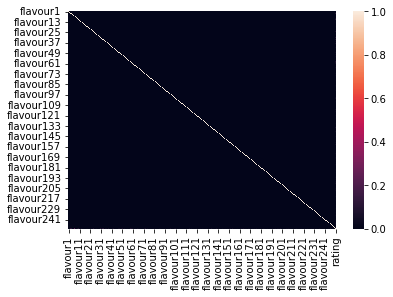

In [231]:
plot_corr = data_processed.loc[:,data_processed.columns.str.startswith("flav")].join(data["rating"]).corr()
sns.heatmap(plot_corr, vmin=0)

In [232]:
pd.set_option('display.max_rows', 78)
data_processed.corrwith(data["rating"])

cocoa_percent    -0.144569
no_ingredients   -0.059256
ingr_1- B        -0.188497
ingr_2- B,C      -0.008782
ingr_2- B,S       0.046533
                    ...   
sweetener        -0.076940
cocoa_butter      0.046211
vanilla          -0.147725
lecithin         -0.051052
salt             -0.046464
Length: 309, dtype: float64

### Scatterplots

#### Review Date

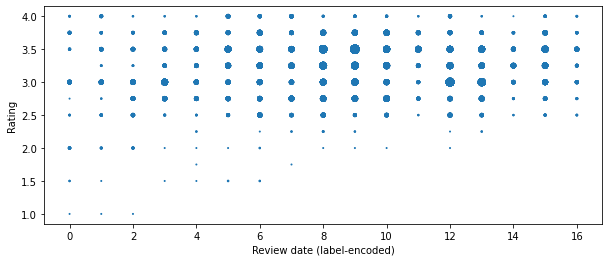

In [287]:
c = Counter(zip(X_train["review_date"], y_train))
s = [c[(n,r)] for n,r in zip(X_train["review_date"], y_train)]

plt.subplots(figsize=(10,4))
plt.scatter(X_train["review_date"], y_train, marker='o', s=s)
plt.xlabel("Review date (label-encoded)")
plt.ylabel("Rating")
plt.savefig("Presentation/review_date.png")
plt.show()

In [234]:
scaler = preprocessing.MinMaxScaler()
review_date_norm_train = scaler.fit_transform(X_train.loc[:, ["review_date"]]).reshape(-1)
review_date_norm_test = scaler.transform(X_test.loc[:, ["review_date"]]).reshape(-1)

X_train["review_date_01"] = review_date_norm_train
X_test["review_date_01"] = review_date_norm_test

In [235]:
print("raw: \t", X_train["review_date_01"].corr(y_train))

for i in np.arange(2,5,1):
    print("^", i, ": \t", (X_train["review_date_01"]**i).corr(y_train))
    
print("exp: \t", X_train["review_date_01"].apply(lambda x: math.exp(x)).corr(y_train))

raw: 	 0.10272970692722698
^ 2 : 	 0.08537886466825112
^ 3 : 	 0.07598692709034569
^ 4 : 	 0.07125172929483586
exp: 	 0.09529189274094543


#### Cocoa Percent

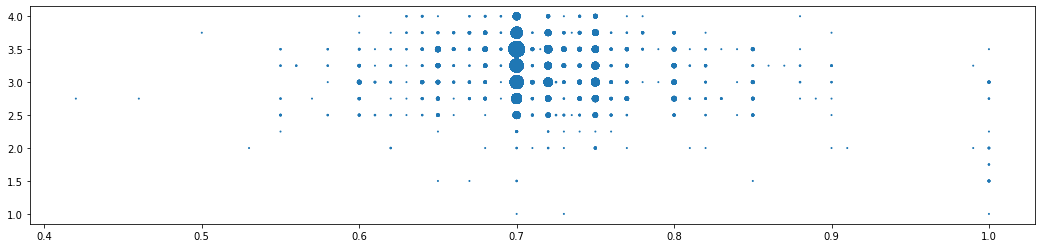

In [236]:
c = Counter(zip(X_train["cocoa_percent"], y_train))
s = [c[(n,r)] for n,r in zip(X_train["cocoa_percent"], y_train)]

plt.figure(figsize=(18,4))
plt.scatter(X_train["cocoa_percent"], y_train, marker='o', s=s)

In [237]:
print("raw: \t", X_train["cocoa_percent"].corr(y_train))

for i in np.arange(2,5,1):
    print("^", i, ": \t", (X_train["cocoa_percent"]**i).corr(y_train))
    
print("exp: \t", X_train["cocoa_percent"].apply(lambda x: math.exp(x)).corr(y_train))
print("log: \t", X_train["cocoa_percent"].apply(lambda x: math.log(x)).corr(y_train))

raw: 	 -0.15468613384454488
^ 2 : 	 -0.17421833595633532
^ 3 : 	 -0.19112448664847756
^ 4 : 	 -0.20511755418418207
exp: 	 -0.16958112954665872
log: 	 -0.13294866479168435


In [238]:
X_train["cocoa_percent_p4"] = X_train["cocoa_percent"]**4
X_test["cocoa_percent_p4"] = X_test["cocoa_percent"]**4

#### Number of Ingredients

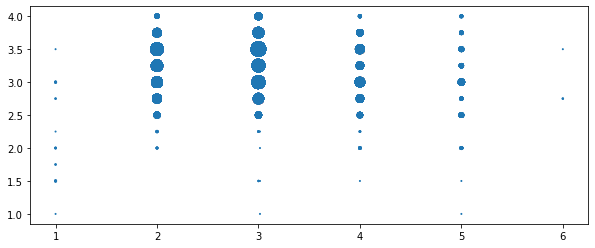

In [239]:
c = Counter(zip(X_train["no_ingredients"], y_train))
s = [c[(n,r)] for n,r in zip(X_train["no_ingredients"], y_train)]

plt.figure(figsize=(10,4))
plt.scatter(X_train["no_ingredients"], y_train, marker='o', s=s)

In [240]:
print("raw: \t", X_train["no_ingredients"].corr(y_train))

for i in np.arange(2,5,1):
    print("^", i, ": \t", (X_train["no_ingredients"]**i).corr(y_train))
    
print("exp: \t", X_train["no_ingredients"].apply(lambda x: math.exp(x)).corr(y_train))
print("log: \t", X_train["no_ingredients"].apply(lambda x: math.log(x)).corr(y_train))

raw: 	 -0.051033273431896405
^ 2 : 	 -0.07686993458664833
^ 3 : 	 -0.09196059014770708
^ 4 : 	 -0.09951207957075418
exp: 	 -0.09744165990994395
log: 	 -0.010776730694139265


In [241]:
X_train["no_ingredients_exp"] = X_train["no_ingredients"].apply(lambda x: math.exp(x))
X_test["no_ingredients_exp"] = X_test["no_ingredients"].apply(lambda x: math.exp(x))

## Lists with groups of variables

In [307]:
baseline_cols = ["review_date", "cocoa_percent"] + data_processed.columns[
    data_processed.columns.str.startswith("ingr_")
].to_list()

raw_numeric_cols = ["review_date", "cocoa_percent"]
scaled_numeric_cols = ["review_date_01", "cocoa_percent_p4"]

ingr_number_col = ["no_ingredients"]
ingr_number_scaled_col = ["no_ingredients_exp"]
ingr_seperated_cols = [
    "sugar",
    "sweetener",
    "cocoa_butter",
    "vanilla",
    "lecithin",
    "salt",
]

ingr_dummy_cols = data_processed.columns[data_processed.columns.str.startswith("ingr_")].to_list()
manufac_dummy_cols = manufacturer_dummies.columns.to_list()
location_dummy_cols = location_dummies.columns.to_list()
origin_dummy_cols = origin_dummies.columns.to_list()
flavour_emb_cols = data_processed.columns[data_processed.columns.str.startswith("flav")].to_list()
flavour_emb_pca95_cols = flavour_emb_cols[0:67]
flavour_emb_pca80_cols = flavour_emb_cols[0:22]

# Methods for Evaluation

In [247]:
def mse(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean()

In [248]:
def print_scores(m, X_train, X_test):
    y_pred_train = m.predict(X_train)
    y_pred = m.predict(X_test)

    # regression
    print(
        "R^2:\t\t",
        "Train: {0:0.4f}".format(m.score(X_train, y_train)),
        ", Valid: {0:0.4f}".format(m.score(X_test, y_test)),
    )
    print("MSE:\t\t\t\t", "Valid: {0:0.4f}".format(mse(y_pred, y_test)))

    # classification:
    targets = np.arange(1, 4, 0.25)
    diff = np.subtract.outer(
        y_pred_train, targets
    )  # substract all targets from each prediction
    i = np.argmin(abs(diff), axis=1)  # closest indices of target to prediction
    y_pred_train_cat = targets[i].astype(str)
    diff = np.subtract.outer(y_pred, targets)
    i = np.argmin(abs(diff), axis=1)
    y_pred_cat = targets[i].astype(str)

    print(
        "Accuracy:\t",
        "Train: {0:0.4f}".format(accuracy_score(y_train_cat, y_pred_train_cat)),
        ", Valid: {0:0.4f}".format(accuracy_score(y_test_cat, y_pred_cat)),
    )

In [249]:
def print_scores_classification(m, X_train, X_test):
    y_pred_train = m.predict(X_train)
    y_pred = m.predict(X_test)

    print(
        "Accuracy:\t",
        "Train: {0:0.4f}".format(accuracy_score(y_train_cat, y_pred_train)),
        ", Valid: {0:0.4f}".format(accuracy_score(y_test_cat, y_pred)),
    )

# Baseline Models

In [74]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [183]:
X_train_bl = X_train.loc[:, baseline_cols]
X_test_bl = X_test.loc[:, baseline_cols]

In [184]:
bl = LinearRegression()
bl.fit(X_train_bl, y_train)
print_scores(bl, X_train_bl, X_test_bl)

R^2:		 Train: 0.1030 , Valid: 0.0691
MSE:				 Valid: 0.1838
Accuracy:	 Train: 0.2005 , Valid: 0.2490


In [299]:
dtc = DecisionTreeClassifier(max_depth=5)
dtc.fit(X_train_bl, y_train_cat)
y_pred_dtc = dtc.predict(X_test_bl)
print_scores_classification(dtc, X_train_bl, X_test_bl)

Accuracy:	 Train: 0.2966 , Valid: 0.2201


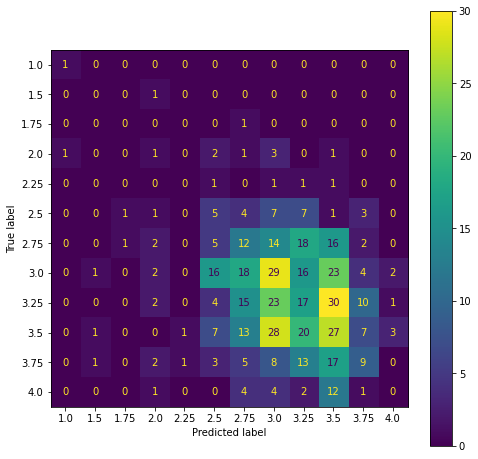

In [182]:
cm = confusion_matrix(y_test_cat, y_pred_dtc)
fig, ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay(cm, display_labels=dtc.classes_)
disp.plot(ax=ax)
plt.show()

# Linear Regression

## Stepwise add features

In [328]:
def lr_dtc(cols):
    X_train_ = X_train.loc[:, cols]
    X_test_ = X_test.loc[:, cols]
    
    print("Linear Regression:")
    lr_ = LinearRegression()
    lr_.fit(X_train_, y_train)
    print_scores(lr_, X_train_, X_test_)
    
    print("\nDecision Tree Classifier:")
    dtc_ = DecisionTreeClassifier(max_depth=5)
    dtc_.fit(X_train_, y_train_cat)
    y_pred_dtc_ = dtc_.predict(X_test_)
    print_scores_classification(dtc_, X_train_, X_test_)

In [319]:
cols = baseline_cols.copy()
lr_dtc(cols)

Linear Regression:
R^2:		 Train: 0.1030 , Valid: 0.0691
MSE:				 Valid: 0.1838
Accuracy:	 Train: 0.2005 , Valid: 0.2490

Decision Tree Classifier:
Accuracy:	 Train: 0.2966 , Valid: 0.2201


In [321]:
cols = baseline_cols + location_dummy_cols + manufac_dummy_cols + origin_dummy_cols
lr_dtc(cols)

Linear Regression:
R^2:		 Train: 0.1514 , Valid: 0.0915
MSE:				 Valid: 0.1794
Accuracy:	 Train: 0.2155 , Valid: 0.2510

Decision Tree Classifier:
Accuracy:	 Train: 0.3048 , Valid: 0.2162


In [326]:
cols = raw_numeric_cols + ingr_number_col + ingr_seperated_cols
lr_dtc(cols)

Linear Regression:
R^2:		 Train: 0.0937 , Valid: 0.0534
MSE:				 Valid: 0.1869
Accuracy:	 Train: 0.2039 , Valid: 0.2375

Decision Tree Classifier:
Accuracy:	 Train: 0.2976 , Valid: 0.2181


In [330]:
cols = baseline_cols + flavour_emb_pca80_cols
lr_dtc(cols)

Linear Regression:
R^2:		 Train: 0.3663 , Valid: 0.3023
MSE:				 Valid: 0.1377
Accuracy:	 Train: 0.2739 , Valid: 0.2857

Decision Tree Classifier:
Accuracy:	 Train: 0.3420 , Valid: 0.2548


In [331]:
cols = scaled_numeric_cols + ingr_number_scaled_col + ingr_dummy_cols
lr_dtc(cols)

Linear Regression:
R^2:		 Train: 0.1062 , Valid: 0.0737
MSE:				 Valid: 0.1829
Accuracy:	 Train: 0.2019 , Valid: 0.2452

Decision Tree Classifier:
Accuracy:	 Train: 0.2966 , Valid: 0.2201


## Full model

In [332]:
import statsmodels.api as sm

In [339]:
regressors_lr = (
    scaled_numeric_cols
    + ingr_number_scaled_col
    + ingr_seperated_cols
    + manufac_dummy_cols
    + location_dummy_cols
    + origin_dummy_cols
    + flavour_emb_pca80_cols
)
print(regressors_lr)

['review_date_01', 'cocoa_percent_p4', 'no_ingredients_exp', 'sugar', 'sweetener', 'cocoa_butter', 'vanilla', 'lecithin', 'salt', 'manufac_Soma', 'manufac_Fresco', 'manufac_Arete', 'manufac_Bonnat', 'manufac_A. Morin', 'loc_U.S.A.', 'loc_France', 'loc_Canada', 'loc_U.K.', 'loc_Italy', 'loc_Belgium', 'loc_Ecuador', 'loc_Australia', 'org_Venezuela', 'org_Peru', 'org_Dominican Republic', 'org_Ecuador', 'org_Madagascar', 'org_Blend', 'org_Nicaragua', 'org_Brazil', 'org_Colombia', 'org_Tanzania', 'org_Bolivia', 'org_Belize', 'org_Vietnam', 'org_Guatemala', 'org_Mexico', 'flavour1', 'flavour2', 'flavour3', 'flavour4', 'flavour5', 'flavour6', 'flavour7', 'flavour8', 'flavour9', 'flavour10', 'flavour11', 'flavour12', 'flavour13', 'flavour14', 'flavour15', 'flavour16', 'flavour17', 'flavour18', 'flavour19', 'flavour20', 'flavour21', 'flavour22']


In [340]:
X_train_lr = X_train.loc[:, regressors_lr]
X_test_lr = X_test.loc[:, regressors_lr]

In [341]:
lr = LinearRegression()
lr.fit(X_train_lr, y_train)
print_scores(lr, X_train_lr, X_test_lr)

R^2:		 Train: 0.3813 , Valid: 0.2975
MSE:				 Valid: 0.1387
Accuracy:	 Train: 0.2812 , Valid: 0.2703


with scaled_numeric_cols, ingr_seperated_cols, location_dummy_cols (5%), origin_dummy_cols (5%) only: $\newline$
Train R2 =  0.11503917722373813 , Valid R2 =  0.057128032451005284 , Valid MSE =  0.19577608470025032

In [186]:
X = sm.add_constant(X_train_lr)
est = sm.OLS(y_train, X).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     21.09
Date:                Wed, 29 Jun 2022   Prob (F-statistic):          5.50e-161
Time:                        09:21:50   Log-Likelihood:                -778.06
No. Observations:                2070   AIC:                             1670.
Df Residuals:                    2013   BIC:                             1991.
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      2

## Backward Elimination

In [187]:
est = sm.OLS(y_train, X).fit()
p = est.pvalues.max()
drop_cols = []

while p > 0.1:
    drop = est.pvalues[est.pvalues==p].index.to_list()
    print("drop:", drop)
    
    drop_cols = drop_cols + drop
    X_reduced = X.loc[:, ~X.columns.isin(drop_cols)]
    est = sm.OLS(y_train, X_reduced).fit()
    
    p = est.pvalues.max()

drop: ['loc_Canada']
drop: ['org_Bolivia']
drop: ['org_Tanzania']
drop: ['flavour18']
drop: ['org_Nicaragua']
drop: ['org_Colombia']
drop: ['loc_France']
drop: ['flavour7']
drop: ['org_Peru']
drop: ['no_ingredients_exp']
drop: ['org_Blend']
drop: ['loc_Italy']
drop: ['org_Vietnam']
drop: ['flavour9']
drop: ['salt']
drop: ['org_Belize']
drop: ['flavour14']
drop: ['flavour11']
drop: ['cocoa_butter']
drop: ['org_Dominican Republic']
drop: ['org_Madagascar']
drop: ['lecithin']
drop: ['org_Guatemala']
drop: ['flavour19']
drop: ['loc_U.K.']


In [188]:
X_train_reduced = X_train_lr.loc[:, ~X_train_lr.columns.isin(drop_cols)]
X_test_reduced = X_test_lr.loc[:, ~X_test_lr.columns.isin(drop_cols)]
print(X_train_reduced.columns)

Index(['review_date_01', 'cocoa_percent_p4', 'sugar', 'sweetener', 'vanilla',
       'manufac_Soma', 'manufac_Fresco', 'manufac_Arete', 'manufac_Bonnat',
       'manufac_A. Morin', 'loc_U.S.A.', 'loc_Belgium', 'loc_Ecuador',
       'loc_Australia', 'org_Venezuela', 'org_Ecuador', 'org_Brazil',
       'org_Mexico', 'flavour1', 'flavour2', 'flavour3', 'flavour4',
       'flavour5', 'flavour6', 'flavour8', 'flavour10', 'flavour12',
       'flavour13', 'flavour15', 'flavour16', 'flavour17'],
      dtype='object')


In [189]:
lr_reduced = LinearRegression()
lr_reduced.fit(X_train_reduced, y_train)
print_scores(lr_reduced, X_train_reduced, X_test_reduced)

R^2:		 Train: 0.3622 , Valid: 0.2668
MSE:				 Valid: 0.1448
Accuracy:	 Train: 0.2763 , Valid: 0.2587


## Lasso

In [342]:
from sklearn.linear_model import Lasso

In [352]:
regressors_clf = (
    scaled_numeric_cols
    + ingr_number_scaled_col
    + ingr_seperated_cols
    + ingr_dummy_cols
    + manufac_dummy_cols
    + location_dummy_cols
    + origin_dummy_cols
    + flavour_emb_pca95_cols
)

In [353]:
X_train_clf = X_train.loc[:, regressors_clf]
X_test_clf = X_test.loc[:, regressors_clf]

In [354]:
clf = Lasso(alpha=0.001)
clf.fit(X_train_clf, y_train)
print_scores(clf, X_train_clf, X_test_clf)

R^2:		 Train: 0.4241 , Valid: 0.3443
MSE:				 Valid: 0.1295
Accuracy:	 Train: 0.2889 , Valid: 0.2934


In [355]:
alphas = np.arange(5e-05, 1e-03, 1e-05)
lasso_score = []
lasso_mse = []

for alpha in alphas:
    clf = Lasso(alpha=alpha)
    clf.fit(X_train_clf, y_train)
    score_ = clf.score(X_test_clf, y_test)
    lasso_score.append(score_)
    mse_ = mse(clf.predict(X_test_clf), y_test)
    lasso_mse.append(mse_)

C:\Users\Ella\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.871e-01, tolerance: 4.078e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ella\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.137e-02, tolerance: 4.078e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ella\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of 

In [356]:
lasso_score_df = pd.DataFrame({"alpha": alphas, "score": lasso_score})
lasso_score_df.loc[lasso_score_df["score"]==lasso_score_df["score"].max(), "alpha"]

1    0.00006
Name: alpha, dtype: float64

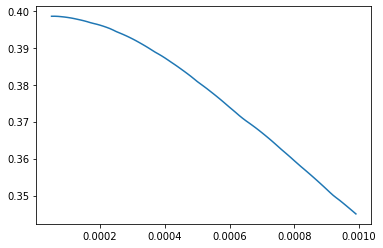

In [357]:
plt.plot(alphas, lasso_score)

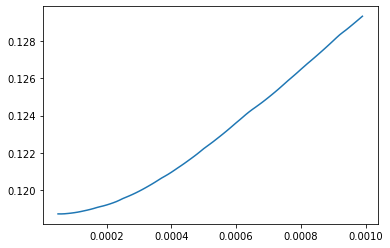

In [358]:
plt.plot(alphas, lasso_mse)

In [360]:
clf = Lasso(alpha=0.00006)
clf.fit(X_train_clf, y_train)
print_scores(clf, X_train_clf, X_test_clf)

R^2:		 Train: 0.5005 , Valid: 0.3985
MSE:				 Valid: 0.1187
Accuracy:	 Train: 0.3425 , Valid: 0.3205


C:\Users\Ella\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.137e-02, tolerance: 4.078e-02
  model = cd_fast.enet_coordinate_descent(


# Random Forests

In [361]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

In [367]:
regressors_rf = (
    scaled_numeric_cols
    + ingr_number_scaled_col
    + ingr_seperated_cols
    + ingr_dummy_cols
    + manufac_dummy_cols
    + location_dummy_cols
    + origin_dummy_cols
    + flavour_emb_pca95_cols
)

In [368]:
X_train_rf = X_train.loc[:, regressors_rf]
X_test_rf = X_test.loc[:, regressors_rf]

In [364]:
dt = DecisionTreeRegressor(min_samples_leaf=100)
dt.fit(X_train_rf, y_train)
print_scores(dt, X_train_rf, X_test_rf)

R^2:		 Train: 0.2320 , Valid: 0.0938
MSE:				 Valid: 0.1789
Accuracy:	 Train: 0.2536 , Valid: 0.2336


In [369]:
rf = RandomForestRegressor(min_samples_leaf=50, max_depth=5, random_state=42)
rf.fit(X_train_rf, y_train)
print_scores(rf, X_train_rf, X_test_rf)

R^2:		 Train: 0.3314 , Valid: 0.2135
MSE:				 Valid: 0.1553
Accuracy:	 Train: 0.2493 , Valid: 0.2606


In [201]:
fi_df = pd.DataFrame(
    data={'Feature': X_train_rf.columns, 'Feature importance': rf.feature_importances_}, 
    columns = ['Feature', 'Feature importance']
)
fi_df.sort_values('Feature importance', inplace=True, ascending=False)

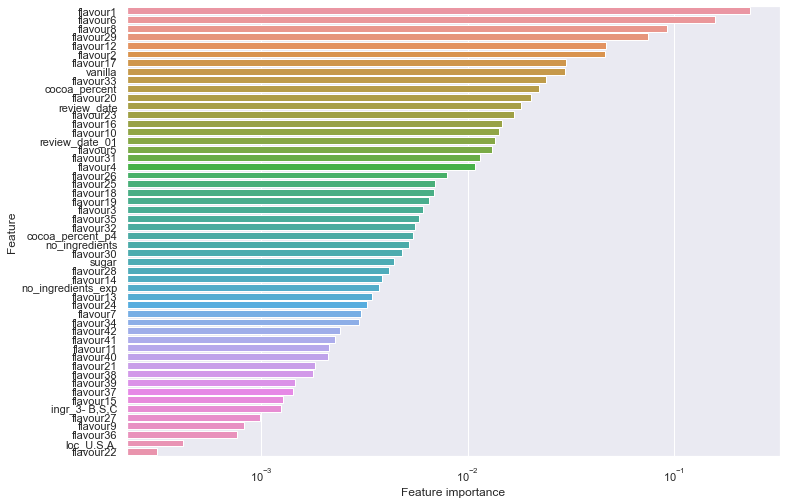

In [202]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(data=fi_df[fi_df["Feature importance"] > 0], x='Feature importance', y='Feature')
plt.xscale('log')

In [203]:
per_imp = permutation_importance(rf, X_train_rf, y_train, n_repeats=1, n_jobs=-1)
pi_df = pd.DataFrame(
    data={'Feature': X_train_rf.columns, 'Permutation importance': per_imp["importances_mean"]}, 
    columns = ['Feature', 'Permutation importance']
)
pi_df.sort_values('Permutation importance', inplace=True, ascending=False)

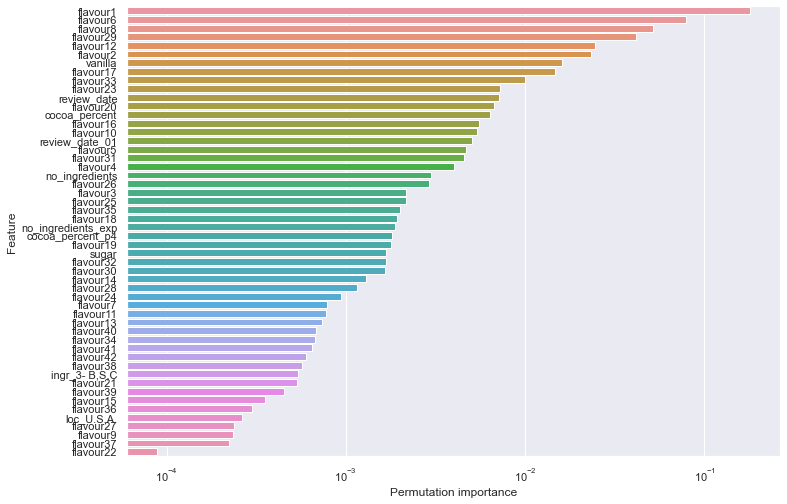

In [204]:
sns.barplot(data=pi_df[pi_df["Permutation importance"] > 0], x='Permutation importance', y='Feature')
plt.xscale('log')

In [205]:
regressors_lr_fi = list(
    set(fi_df[fi_df["Feature importance"] > 0].Feature).intersection(
        pi_df[pi_df["Permutation importance"] > 0].Feature
    )
)
regressors_lr_fi

['flavour3',
 'flavour21',
 'cocoa_percent',
 'flavour23',
 'flavour2',
 'flavour40',
 'flavour13',
 'loc_U.S.A.',
 'ingr_3- B,S,C',
 'review_date_01',
 'flavour38',
 'review_date',
 'flavour12',
 'flavour42',
 'flavour31',
 'flavour15',
 'flavour18',
 'flavour36',
 'no_ingredients_exp',
 'flavour41',
 'flavour27',
 'flavour33',
 'flavour8',
 'flavour26',
 'flavour29',
 'flavour19',
 'flavour4',
 'flavour24',
 'sugar',
 'flavour14',
 'flavour10',
 'flavour5',
 'vanilla',
 'cocoa_percent_p4',
 'flavour39',
 'flavour37',
 'flavour22',
 'flavour32',
 'flavour25',
 'flavour16',
 'flavour7',
 'flavour9',
 'flavour6',
 'flavour11',
 'flavour20',
 'flavour30',
 'flavour1',
 'flavour28',
 'flavour17',
 'no_ingredients',
 'flavour34',
 'flavour35']

In [206]:
# repeat linear regression with features selected by importance in random forest
X_train_lr_fi = X_train.loc[:, regressors_lr_fi]
X_test_lr_fi = X_test.loc[:, regressors_lr_fi]

lr_reduced = LinearRegression()
lr_reduced.fit(X_train_lr_fi, y_train)
print_scores(lr_reduced, X_train_lr_fi, X_test_lr_fi)

R^2:		 Train: 0.4302 , Valid: 0.3663
MSE:				 Valid: 0.1251
Accuracy:	 Train: 0.3005 , Valid: 0.2915
